# Before Analysis...

In [ ]:
import numpy as np
import mne
import sklearn
import matplotlib.pyplot as plt
from scipy import stats
from decimal import Decimal, getcontext
import pandas as pd
import ast
import openpyxl as op
import re

In [4]:
# 분석대상 이름 입력
# 실행 전 경로 및 파일명 확인 필요

name_raw = input("분석대상 이름을 입력하세요.")

# Loading saved TFR file
file_path = rf'H:\Mg_EEG\tfr_files_gamma\{name_raw}_7200_tfr.h5'
tfr = mne.time_frequency.read_tfrs(file_path)
print(f"성공적으로 {name_raw}의 tfr 파일을 로딩하였습니다.")

# Saving raw file for back-up
tfr_raw = tfr.copy()
print(f"{name_raw}의 raw 파일을 백업하였습니다.")

# plot 작성을 위한 TFR 평균 계산산
def tfr_mean(tfr):
    mean_electrode = np.mean(tfr.data, axis=0) # Averaging across electrode
    mean_frequency = np.mean(mean_electrode, axis=0) # Averaging across frequency
    return(mean_frequency)

# name에서 알파벳만 제거하여 이름 복구
name = re.sub(r'[a-zA-Z]', '', name_raw)
print(name)
print(f"{name}의 TFR을 분석합니다.")

Reading H:\Mg_EEG\tfr_files_gamma\김가람gamma_7200_tfr.h5 ...
성공적으로 김가람gamma의 tfr 파일을 로딩하였습니다.
김가람gamma의 raw 파일을 백업하였습니다.
김가람
김가람의 TFR을 분석합니다.


In [ ]:
#raw fif file 보고 싶다면 사용
# clean_data.plot()

In [ ]:
#데이터가 뭔가 이상할 때 리셋하는 복구 코드
#tfr = tfr_raw

In [ ]:
# large artifact data load
csv_file_path = r'C:\Users\esin4\OneDrive\바탕 화면\Github\Mg_infusion_coma\large_artifact.csv'

large_artifact_data = pd.read_csv(csv_file_path, encoding='utf-8-sig')

# 입력한 이름이 데이터프레임에 존재하는지 확인하고 좌표 가져오기
if name in large_artifact_data['Name'].values:
    # 입력한 이름에 해당하는 데이터 가져오기
    coordinates = large_artifact_data[large_artifact_data['Name'] == name]['Coordinates'].values[0]
    
    # 좌표가 'skip'이면 빈 리스트로 설정
    if coordinates == 'skip':
        large_artifact = []
    else:
        # 좌표 문자열을 리스트로 변환
        import ast
        large_artifact = ast.literal_eval(coordinates)
# 입력한 이름이 데이터프레임에 없으면 빈 리스트로 설정
else:
    print(f"{name}이(가) 데이터에 없습니다.")
    large_artifact = []

# 결과 출력
print("large_artifact 리스트:")
print(large_artifact)

large_artifact 리스트:
[(10, 18), (30, 40), (876, 881), (1108, 1115), (3951, 3952), (4985, 4994), (5625, 5642)]


In [6]:
# 분석한 값 저장할 엑셀 파일
wb = op.load_workbook(r"C:\Users\esin4\OneDrive\바탕 화면\Github\Mg_infusion_coma\Mg_infusion_data.xlsx")
row = int(input("데이터가 입력될 행을 입력하세요."))

# independent t-test

In [ ]:
# Before vs After segmentation
tfr_before = tfr.copy().crop(tmin=0, tmax=3600, include_tmax=False)
tfr_after = tfr.copy().crop(tmin=3600, tmax=7199, include_tmax=False)

# Averaging
before_mean = tfr_mean(tfr_before)
after_mean = tfr_mean(tfr_after)

# Indexing about Large artifact
before_idx = []
after_idx = []

for t_start, t_end in large_artifact:
    if t_start < 3600 and t_end < 3600:
        before_idx.extend(range(t_start*200, t_end*200))
    elif t_start < 3600 and t_end >= 3600:
        before_idx.extend(range(t_start*200, 3600*200))
        after_idx.extend(range(0, (t_end-3600)*200))
    else:
        after_idx.extend(range((t_start-3600)*200, (t_end-3600)*200))

# Removing Large artifacts
before_mean_clean = np.delete(before_mean, before_idx)
after_mean_clean = np.delete(after_mean, after_idx)

# independent t-test
# precision
getcontext().prec = 50

print(f"{name}, independent t test")
# mean of before vs after
mean_before = np.mean(before_mean_clean)
mean_after = np.mean(after_mean_clean)
print("mean_before : \n", mean_before)
print("mean_after : \n", mean_after)

# t-test
t_stat, p_value = stats.ttest_ind(before_mean_clean, after_mean_clean)

# print to decimal object
p_value_decimal = Decimal(p_value)
print ("t_statistics : \n", t_stat)
p_value_str = f"{p_value_decimal:.100f}"
p_value_num = float(p_value_str)
print(f"p-value: \n {p_value_str}")

# Define Cohens'D 
def cohens_d(group1, group2):
    # Calculate mean, sd
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    
    # sample size
    n1, n2 = len(group1), len(group2)
    
    # Calculate pooled sd
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    
    # Cohen's d
    d = (mean1 - mean2) / pooled_std
    return d

# Calculate Effect Size
effect_size = cohens_d(before_mean, after_mean)
print("effect size \n", effect_size)

In [ ]:
# Save to Excel
ws_i = wb["independent t"]
ws_i.cell(row=row, column=1).value = f"{name}"
ws_i.cell(row=row, column=2).value = mean_before
ws_i.cell(row=row, column=3).value = mean_after
ws_i.cell(row=row, column=4).value = t_stat
ws_i.cell(row=row, column=5).value = p_value
ws_i.cell(row=row, column=7).value = effect_size

# Paired t-test

In [ ]:
# Before vs After segmentation
tfr_before = tfr.copy().crop(tmin=0, tmax=3600, include_tmax=False)
tfr_after = tfr.copy().crop(tmin=3600, tmax=7199, include_tmax=False)

# Averaging
before_mean = tfr_mean(tfr_before)
after_mean = tfr_mean(tfr_after)

# trim the data 무조건 7200초 맞춰서 이 부분 안 써도 되도록 해야함. 
if len(before_mean) > len(after_mean):
    before_mean = before_mean[:len(after_mean)]
elif len(before_mean) < len(after_mean):
    after_mean = after_mean[:len(before_mean)]
else:
    quit

len(before_mean) == len(after_mean)

# Indexing about large artifact

before_idx = set()
after_idx = set()

for t_start, t_end in large_artifact:
    if t_start < 3600 and t_end < 3600:
        before_idx.update(range(t_start*200, t_end*200))
        after_idx.update(range(t_start*200, t_end*200))
    elif t_start < 3600 and t_end >= 3600:
        before_idx.update(range(t_start*200, 3600*200))
        after_idx.update(range(t_start*200, 3600*200))
        after_idx.update(range(0, (t_end-3600)*200))
        before_idx.update(range(0, (t_end-3600)*200))
    else:
        after_idx.update(range((t_start-3600)*200, (t_end-3600)*200))
        before_idx.update(range((t_start-3600)*200, (t_end-3600)*200))

# Convert sets back to sorted lists
before_idx = sorted(before_idx)
after_idx = sorted(after_idx)

before_mean_clean = np.delete(before_mean, before_idx)
after_mean_clean = np.delete(after_mean, after_idx)

# Paired t-test
# precision
getcontext().prec = 50

print(f"{name}, paired t test")
# mean of before vs after
mean_before = np.mean(before_mean_clean)
mean_after = np.mean(after_mean_clean)
print("mean_before :\n ", mean_before)
print("mean_after : \n", mean_after)

# Kolmogorov-Smirnov test
difference = before_mean_clean-after_mean_clean
ks_statistic, ks_p_value = stats.kstest(difference, stats.norm.cdf)
print(f"KS Statistic: \n {ks_statistic}")
print(f"KS p-value: \n {ks_p_value}")

# t-test
t_stat, p_value = stats.ttest_rel(before_mean, after_mean)

# print to decimal object
p_value_decimal = Decimal(p_value)
print ("t_statistics : \n", t_stat)
p_value_str = f"{p_value_decimal:.100f}"
print(f"p-value: \n {p_value_str}")

# Define Cohens'D 
def cohens_d(group1, group2):
    # Calculate mean, sd
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    
    # sample size
    n1, n2 = len(group1), len(group2)
    
    # Calculate pooled sd
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    
    # Cohen's d
    d = (mean1 - mean2) / pooled_std
    return d

# Calculate Effect Size
effect_size = cohens_d(before_mean, after_mean)
print("effect size \n", effect_size)

In [ ]:
# Save to Excel
ws_p = wb["paired t"]
ws_p.cell(row=row, column=1).value = f"{name}"
ws_p.cell(row=row, column=2).value = mean_before
ws_p.cell(row=row, column=3).value = mean_after
ws_p.cell(row=row, column=4).value = ks_statistic
ws_p.cell(row=row, column=5).value = ks_p_value
ws_p.cell(row=row, column=7).value = t_stat
ws_p.cell(row=row, column=8).value = p_value
ws_p.cell(row=row, column=10).value = effect_size

# Analysis across Band

## Paired t-test with Cohen's D test

In [ ]:
# 주파수 대역별로 처리
freq_ranges = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'gamma': (30, 90)
}

# Averaging by band and timing
for band, (fmin, fmax) in freq_ranges.items():
    tfr_band_before = tfr.copy().crop(tmin=0, tmax=3600, fmin=fmin, fmax=fmax, include_tmax=False)
    tfr_band_after = tfr.copy().crop(tmin=3600, tmax=7199, fmin=fmin, fmax=fmax, include_tmax=False)

    globals()[f'tfr_{band}_before'] = tfr_band_before
    globals()[f'tfr_{band}_after'] = tfr_band_after

    globals()[f'{band}_before_mean'] = tfr_mean(tfr_band_before)
    globals()[f'{band}_after_mean'] = tfr_mean(tfr_band_after)

# Make length same    
for band in freq_ranges.keys():
    before_mean = globals()[f'{band}_before_mean']
    after_mean = globals()[f'{band}_after_mean']

    if len(before_mean) > len(after_mean):
        globals()[f'{band}_before_mean'] = before_mean[:len(after_mean)]
    elif len(before_mean) < len(after_mean):
        globals()[f'{band}_after_mean'] = after_mean[:len(before_mean)]
    else:
        print(f"{band} 대역의 before와 after 길이가 이미 같습니다.")

    print(f"{band} 대역 처리 완료: before 길이 = {len(globals()[f'{band}_before_mean'])}, after 길이 = {len(globals()[f'{band}_after_mean'])}")

# Removing large artifact by band
def remove_artifacts(before_mean, after_mean, large_artifact):
    before_idx = set()
    after_idx = set()

    for t_start, t_end in large_artifact:
        if t_start < 3600 and t_end < 3600:
            before_idx.update(range(t_start*200, t_end*200))
            after_idx.update(range(t_start*200, t_end*200))
        elif t_start < 3600 and t_end >= 3600:
            before_idx.update(range(t_start*200, 3600*200))
            after_idx.update(range(t_start*200, 3600*200))
            after_idx.update(range(0, (t_end-3600)*200))
            before_idx.update(range(0, (t_end-3600)*200))
        else:
            after_idx.update(range((t_start-3600)*200, (t_end-3600)*200))
            before_idx.update(range((t_start-3600)*200, (t_end-3600)*200))

    before_idx = sorted(before_idx)
    after_idx = sorted(after_idx)

    before_mean_clean = np.delete(before_mean, before_idx)
    after_mean_clean = np.delete(after_mean, after_idx)

    return before_mean_clean, after_mean_clean

# 주파수 대역별로 artifact 제거
for band in freq_ranges.keys():
    before_mean = globals()[f'{band}_before_mean']
    after_mean = globals()[f'{band}_after_mean']

    before_mean_clean, after_mean_clean = remove_artifacts(before_mean, after_mean, large_artifact)

    globals()[f'{band}_before_mean_clean'] = before_mean_clean
    globals()[f'{band}_after_mean_clean'] = after_mean_clean

    print(f"{band} 대역 처리 완료:")
    print(f"  Before: 원본 길이 = {len(before_mean)}, 정제 후 길이 = {len(before_mean_clean)}")
    print(f"  After: 원본 길이 = {len(after_mean)}, 정제 후 길이 = {len(after_mean_clean)}")
    print(f"  정제 후 Before와 After 길이 일치: {len(before_mean_clean) == len(after_mean_clean)}")

print(f"\n {name}, paired t test by band")

# 테스트 실행 함수
def run_tests(before_mean, after_mean, band_name):
    print(f"\n=== {band_name} 대역 분석 결과 ===")
    
    # precision
    getcontext().prec = 50

    # mean of before vs after
    mean_before = np.mean(before_mean)
    mean_after = np.mean(after_mean)
    print(f"mean_before: \n {mean_before}")
    print(f"mean_after: \n {mean_after}")

    # Kolmogorov-Smirnov test
    difference = before_mean - after_mean
    ks_statistic, ks_p_value = stats.kstest(difference, stats.norm.cdf)
    print(f"KS Statistic: \n {ks_statistic}")
    print(f"KS p-value: \n {ks_p_value}")

    # t-test
    t_stat, p_value = stats.ttest_rel(before_mean, after_mean)

    # print to decimal object
    p_value_decimal = Decimal(p_value)
    print(f"t_statistics: \n {t_stat}")
    p_value_str = f"{p_value_decimal:.100f}"
    print(f"p-value: \n {p_value_str}")

    # Define Cohens'D 
    def cohens_d(group1, group2):
        mean1, mean2 = np.mean(group1), np.mean(group2)
        std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
        n1, n2 = len(group1), len(group2)
        pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
        d = (mean1 - mean2) / pooled_std
        return d

    # Calculate Effect Size
    effect_size = cohens_d(before_mean, after_mean)
    print(f"Effect size: \n {effect_size}")

    # 엑셀에 저장
    ws_b = wb["Sheet1"]
    if band_name == 'Delta':
        row_b = row*5-8
    elif band_name == 'Theta':
        row_b = row*5-7
    elif band_name == 'Alpha':
        row_b = row*5-6
    elif band_name == 'Beta':
        row_b = row*5-5
    elif band_name == 'gamma':
        row_b = row*5-4
    else:
        print("오류가 발생하였습니다.")
        return
    
    ws_b.cell(row=row_b, column=1).value = f"{name}"
    ws_b.cell(row=row_b, column=4).value = mean_before
    ws_b.cell(row=row_b, column=5).value = mean_after
    ws_b.cell(row=row_b, column=6).value = ks_statistic
    ws_b.cell(row=row_b, column=7).value = ks_p_value
    ws_b.cell(row=row_b, column=9).value = t_stat
    ws_b.cell(row=row_b, column=10).value = p_value
    ws_b.cell(row=row_b, column=12).value = effect_size

# 각 주파수 대역별로 테스트 실행
for band in freq_ranges.keys():
    before_mean = globals()[f'{band}_before_mean_clean']
    after_mean = globals()[f'{band}_after_mean_clean']
    run_tests(before_mean, after_mean, band)

Delta 대역 처리 완료: before 길이 = 719800, after 길이 = 719800
Theta 대역 처리 완료: before 길이 = 719800, after 길이 = 719800
Alpha 대역 처리 완료: before 길이 = 719800, after 길이 = 719800
Beta 대역 처리 완료: before 길이 = 719800, after 길이 = 719800
gamma 대역 처리 완료: before 길이 = 719800, after 길이 = 719800
Delta 대역 처리 완료:
  Before: 원본 길이 = 719800, 정제 후 길이 = 708400
  After: 원본 길이 = 719800, 정제 후 길이 = 708400
  정제 후 Before와 After 길이 일치: True
Theta 대역 처리 완료:
  Before: 원본 길이 = 719800, 정제 후 길이 = 708400
  After: 원본 길이 = 719800, 정제 후 길이 = 708400
  정제 후 Before와 After 길이 일치: True
Alpha 대역 처리 완료:
  Before: 원본 길이 = 719800, 정제 후 길이 = 708400
  After: 원본 길이 = 719800, 정제 후 길이 = 708400
  정제 후 Before와 After 길이 일치: True
Beta 대역 처리 완료:
  Before: 원본 길이 = 719800, 정제 후 길이 = 708400
  After: 원본 길이 = 719800, 정제 후 길이 = 708400
  정제 후 Before와 After 길이 일치: True
gamma 대역 처리 완료:
  Before: 원본 길이 = 719800, 정제 후 길이 = 708400
  After: 원본 길이 = 719800, 정제 후 길이 = 708400
  정제 후 Before와 After 길이 일치: True

 김가람, paired t test by band

=== Delta 대역 분석 결과 ===
mean_befo

In [8]:
# Save DATA to Excel
wb.save(r"C:\Users\esin4\OneDrive\바탕 화면\Github\Mg_infusion_coma\Mg_infusion_data.xlsx")

## 실험적 접근

Relative Power

In [1]:
import pandas as pd

# Load the specific sheet into a DataFrame
sheet_name = input("불러올 시트 이름을 입력하세요: ")
df = pd.read_excel(r"C:\Users\esin4\OneDrive\바탕 화면\Github\Mg_infusion_coma\Mg_infusion_data.xlsx", sheet_name=sheet_name)

# Display the DataFrame
display(df)

,name,band,id,mean_before,mean_after,ks_statistics,ks_p_value_real,ks_p_value,t_statistics,t_p_value_real,t_p_value,effect_size
0,고정실,delta,NaN,1.703294e-08,3.241658e-09,0.5,0,NaN,2026.308554,0.000000e+00,NaN,3.481290
1,고정실,theta,NaN,5.616056e-09,9.920564e-10,0.5,0,NaN,1735.526863,0.000000e+00,NaN,3.039352
2,고정실,alpha,NaN,9.354715e-10,1.989846e-10,0.5,0,NaN,1395.359653,0.000000e+00,NaN,2.447981
3,고정실,beta,NaN,1.141392e-10,6.668991e-11,0.5,0,NaN,466.938620,0.000000e+00,NaN,0.796543
4,고정실,gamma,NaN,1.616524e-11,2.009946e-11,0.5,0,NaN,-97.545901,0.000000e+00,NaN,-0.164123
...,...,...,...,...,...,...,...,...,...,...,...,...
105,조진욱,delta,NaN,1.463215e-08,2.716271e-09,0.5,0,NaN,53.196462,0.000000e+00,NaN,0.099653
106,조진욱,theta,NaN,2.460651e-09,7.497018e-10,0.5,0,NaN,29.848429,1.303914e-195,NaN,0.055923
107,조진욱,alpha,NaN,1.402035e-09,5.321387e-10,0.5,0,NaN,17.223728,1.832443e-66,NaN,0.032269
108,조진욱,beta,NaN,3.255450e-10,9.888629e-11,0.5,0,NaN,17.366566,1.538672e-67,NaN,0.032538


In [3]:
df_pre = df.loc[:, ['name', 'band', 'mean_before', 'mean_after']]

In [4]:
df_pre['Effect'] = df_pre['mean_before'] > df_pre['mean_after']

In [ ]:
# 전체 중 효과있었던 밴드의 비율
(df_pre.groupby('band')['Effect'].sum())/len(df_pre)

band
alpha    0.109091
beta     0.136364
delta    0.136364
gamma    0.072727
theta    0.136364
Name: Effect, dtype: float64

In [6]:
df_pivot = df_pre.pivot(index='name', columns='band', values='Effect').reset_index()

In [7]:
df_pivot = df_pivot[['name', 'delta', 'theta', 'alpha', 'beta', 'gamma']]

In [8]:
df_pivot

band,name,delta,theta,alpha,beta,gamma
0,고정실,True,True,True,True,False
1,김가람,True,True,True,False,False
2,김득실,False,False,False,False,False
3,김영현,False,False,False,False,True
4,김정한,True,True,True,True,False
5,김충연,True,True,True,True,True
6,민병춘1,True,False,False,True,False
7,박주연1,False,False,False,True,False
8,박주연2,False,True,True,False,False
9,벌,True,True,False,False,False


In [9]:
eye_list = ['Y', 'Y-N', 'N', 'N', 'Y', 'Y-N', 'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'N']

In [10]:
df_pivot['Eye'] = eye_list

In [11]:
df_pivot

band,name,delta,theta,alpha,beta,gamma,Eye
0,고정실,True,True,True,True,False,Y
1,김가람,True,True,True,False,False,Y-N
2,김득실,False,False,False,False,False,N
3,김영현,False,False,False,False,True,N
4,김정한,True,True,True,True,False,Y
5,김충연,True,True,True,True,True,Y-N
6,민병춘1,True,False,False,True,False,N
7,박주연1,False,False,False,True,False,N
8,박주연2,False,True,True,False,False,N
9,벌,True,True,False,False,False,N


In [12]:
df_pivot['Eye_TF'] = (df_pivot['Eye'] == 'Y') | (df_pivot['Eye'] == 'Y-N')

In [13]:
df_pivot.loc[df_pivot['Eye_TF']==True]

band,name,delta,theta,alpha,beta,gamma,Eye,Eye_TF
0,고정실,True,True,True,True,False,Y,True
1,김가람,True,True,True,False,False,Y-N,True
4,김정한,True,True,True,True,False,Y,True
5,김충연,True,True,True,True,True,Y-N,True
12,이귀임,True,True,True,True,True,Y,True
15,전창희,True,True,False,True,False,Y,True


In [14]:
import scipy.stats as stats
from scipy.stats import chi2_contingency
import numpy as np

def analyze_categorical_association(df, wave_band):
    # 교차표 생성
    contingency = pd.crosstab(df[wave_band], df['Eye_TF'])
    
    # 카이제곱 검정
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    
    # Cramer's V 계산
    n = contingency.sum().sum()
    min_dim = min(contingency.shape) - 1
    cramer_v = np.sqrt(chi2 / (n * min_dim))
    
    return {
        'wave_band': wave_band,
        'chi2': chi2,
        'p_value': p_value,
        'cramer_v': cramer_v
    }

# 각 뇌파 대역에 대해 분석 수행
results = []
for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
    result = analyze_categorical_association(df_pivot, band)
    results.append(result)

# 결과를 데이터프레임으로 정리
results_df = pd.DataFrame(results)
print("\n연관성 분석 결과:")
print(results_df.round(4))


연관성 분석 결과:
  wave_band    chi2  p_value  cramer_v
0     delta  2.0974   0.1475    0.3088
1     theta  2.0974   0.1475    0.3088
2     alpha  1.3922   0.2380    0.2516
3      beta  0.1768   0.6742    0.0896
4     gamma  0.0000   1.0000    0.0000


In [15]:
# relative power 계산
df_pre['mean_before_total'] = df_pre.groupby('name')['mean_before'].transform('sum')
df_pre['mean_after_total'] = df_pre.groupby('name')['mean_after'].transform('sum')
df_pre['relative_before'] = df_pre['mean_before'] / df_pre['mean_before_total']
df_pre['relative_after'] = df_pre['mean_after'] / df_pre['mean_after_total']

In [31]:
df_pre

,name,band,mean_before,mean_after,Effect,mean_before_total,mean_after_total,relative_before,relative_after
0,고정실,delta,1.703294e-08,3.241658e-09,True,2.371477e-08,4.519489e-09,0.718242,0.717262
1,고정실,theta,5.616056e-09,9.920564e-10,True,2.371477e-08,4.519489e-09,0.236817,0.219506
2,고정실,alpha,9.354715e-10,1.989846e-10,True,2.371477e-08,4.519489e-09,0.039447,0.044028
3,고정실,beta,1.141392e-10,6.668991e-11,True,2.371477e-08,4.519489e-09,0.004813,0.014756
4,고정실,gamma,1.616524e-11,2.009946e-11,False,2.371477e-08,4.519489e-09,0.000682,0.004447
...,...,...,...,...,...,...,...,...,...
105,조진욱,delta,1.463215e-08,2.716271e-09,True,1.887477e-08,4.102613e-09,0.775223,0.662083
106,조진욱,theta,2.460651e-09,7.497018e-10,True,1.887477e-08,4.102613e-09,0.130367,0.182738
107,조진욱,alpha,1.402035e-09,5.321387e-10,True,1.887477e-08,4.102613e-09,0.074281,0.129707
108,조진욱,beta,3.255450e-10,9.888629e-11,True,1.887477e-08,4.102613e-09,0.017248,0.024103


In [16]:
eye_list1 = []
for i in eye_list:
    eye_list1.append(i)
    eye_list1.append(i)
    eye_list1.append(i)
    eye_list1.append(i)
    eye_list1.append(i)
eye_list1

['Y',
 'Y',
 'Y',
 'Y',
 'Y',
 'Y-N',
 'Y-N',
 'Y-N',
 'Y-N',
 'Y-N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'Y',
 'Y',
 'Y',
 'Y',
 'Y',
 'Y-N',
 'Y-N',
 'Y-N',
 'Y-N',
 'Y-N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'Y',
 'Y',
 'Y',
 'Y',
 'Y',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'Y',
 'Y',
 'Y',
 'Y',
 'Y',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N']

In [17]:
df_pre['Eye_TF'] = eye_list1

In [18]:
df_pre

,name,band,mean_before,mean_after,Effect,mean_before_total,mean_after_total,relative_before,relative_after,Eye_TF
0,고정실,delta,1.703294e-08,3.241658e-09,True,2.371477e-08,4.519489e-09,0.718242,0.717262,Y
1,고정실,theta,5.616056e-09,9.920564e-10,True,2.371477e-08,4.519489e-09,0.236817,0.219506,Y
2,고정실,alpha,9.354715e-10,1.989846e-10,True,2.371477e-08,4.519489e-09,0.039447,0.044028,Y
3,고정실,beta,1.141392e-10,6.668991e-11,True,2.371477e-08,4.519489e-09,0.004813,0.014756,Y
4,고정실,gamma,1.616524e-11,2.009946e-11,False,2.371477e-08,4.519489e-09,0.000682,0.004447,Y
...,...,...,...,...,...,...,...,...,...,...
105,조진욱,delta,1.463215e-08,2.716271e-09,True,1.887477e-08,4.102613e-09,0.775223,0.662083,N
106,조진욱,theta,2.460651e-09,7.497018e-10,True,1.887477e-08,4.102613e-09,0.130367,0.182738,N
107,조진욱,alpha,1.402035e-09,5.321387e-10,True,1.887477e-08,4.102613e-09,0.074281,0.129707,N
108,조진욱,beta,3.255450e-10,9.888629e-11,True,1.887477e-08,4.102613e-09,0.017248,0.024103,N


In [19]:
def prepare_data(data_df):
    """
    원본 데이터를 Repeated Measures ANOVA에 적합한 형태로 변환
    
    Parameters:
    data_df: DataFrame with columns ['name', 'band', 'relative_before', 'relative_after']
    
    Returns:
    DataFrame with columns ['name', 'band', 'Condition', 'mean']
    """
    # 데이터를 long format으로 변환
    before_df = data_df[['name', 'band', 'mean_before', 'relative_before']].rename(
        columns={'relative_before': 'relative_power', 'mean_before': 'mean_power'})
    before_df['Condition'] = 'before'
    
    after_df = data_df[['name', 'band', 'mean_after', 'relative_after']].rename(
        columns={'relative_after': 'relative_power', 'mean_after': 'mean_power'})
    after_df['Condition'] = 'after'
    
    # 데이터 합치기
    long_df = pd.concat([before_df, after_df], ignore_index=True)
    
    return long_df

prepare_data(df_pre)

,name,band,mean_power,relative_power,Condition
0,고정실,delta,1.703294e-08,0.718242,before
1,고정실,theta,5.616056e-09,0.236817,before
2,고정실,alpha,9.354715e-10,0.039447,before
3,고정실,beta,1.141392e-10,0.004813,before
4,고정실,gamma,1.616524e-11,0.000682,before
...,...,...,...,...,...
215,조진욱,delta,2.716271e-09,0.662083,after
216,조진욱,theta,7.497018e-10,0.182738,after
217,조진욱,alpha,5.321387e-10,0.129707,after
218,조진욱,beta,9.888629e-11,0.024103,after


In [40]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.anova import AnovaRM
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def prepare_data(data_df):
    """
    원본 데이터를 Repeated Measures ANOVA에 적합한 형태로 변환
    
    Parameters:
    data_df: DataFrame with columns ['name', 'band', 'relative_before', 'relative_after']
    
    Returns:
    DataFrame with columns ['name', 'band', 'Condition', 'mean']
    """
    # 데이터를 long format으로 변환
    before_df = data_df[['name', 'band', 'relative_before']].rename(
        columns={'relative_before': 'relative_power'})
    before_df['Condition'] = 'before'
    
    after_df = data_df[['name', 'band', 'relative_after']].rename(
        columns={'relative_after': 'relative_power'})
    after_df['Condition'] = 'after'
    
    # 데이터 합치기
    long_df = pd.concat([before_df, after_df], ignore_index=True)
    
    return long_df

def analyze_eeg_data(data_df):
    """
    Two-way Repeated Measures ANOVA 분석 함수
    
    Parameters:
    data_df: DataFrame with columns ['name', 'band', 'relative_before', 'relative_after']
    """
    # 데이터 변환
    long_data = prepare_data(data_df)
    
    # 1. Repeated Measures ANOVA 실행
    rm_anova = AnovaRM(long_data, 'relative_power', 'name', within=['Condition', 'band'])
    result = rm_anova.fit()
    
    # 2. 정규성 검정
    conditions = ['before', 'after']
    bands = data_df['band'].unique()
    
    print("Shapiro-Wilk Normality Test:")
    for cond in conditions:
        for band in bands:
            subset = long_data[(long_data['Condition'] == cond) & 
                             (long_data['band'] == band)]['relative_power']
            stat, p = stats.shapiro(subset)
            print(f"{cond}-{band}: W={stat:.3f}, p={p:.3f}")
    
    # 3-1. 사후 분석 (by T test)
    def post_hoc_analysis_ttest(data_df):
        post_hoc_results = []
        for band in bands:
            band_data = data_df[data_df['band'] == band]
            t_stat, p_val = stats.ttest_rel(
                band_data['relative_before'],
                band_data['relative_after']
            )
            post_hoc_results.append({
                'band': band,
                't_statistic': t_stat,
                'p_value': p_val
            })
        return pd.DataFrame(post_hoc_results)
    

    # 3-2. 사후 분석 (by Tukey HSD)
    def post_hoc_analysis_tukey(data_df):
        """
        Tukey HSD를 사용한 post-hoc 분석
    
        Parameters:
        data_df: DataFrame with columns ['name', 'band', 'relative_before', 'relative_after']
    
        Returns:
        Dictionary containing Tukey HSD results for each band
        """
        # 데이터를 long format으로 변환
        long_data = prepare_data(data_df)
    
        tukey_results = {}
        for band in data_df['band'].unique():
            # 해당 밴드의 데이터만 선택
            band_data = long_data[long_data['band'] == band]
        
            # Tukey HSD 분석 수행
            tukey = pairwise_tukeyhsd(
                endog=band_data['relative_power'],
                groups=band_data['Condition'],
                alpha=0.05
            )
        
            tukey_results[band] = tukey
    
        return tukey_results
    
    # 4. 시각화
    def plot_results(long_data):
        # Boxplot
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='band', y='relative_power', hue='Condition', data=long_data)
        plt.title('Mean Values by Band and Condition')
        plt.show()
        
        # Interaction plot
        plt.figure(figsize=(12, 6))
        means = long_data.groupby(['band', 'Condition'])['relative_power'].mean().unstack()
        means.plot(marker='o')
        plt.title('Interaction Plot: Band x Condition')
        plt.ylabel('Relative Power Value')
        plt.grid(True)
        plt.show()
    
    return {
        'anova_results': result,
        'post_hoc_ttest': post_hoc_analysis_ttest(data_df),
        'post_hoc_tukey': post_hoc_analysis_tukey(data_df),
        'plot_function': lambda: plot_results(long_data)
    }

In [41]:
results = analyze_eeg_data(df_pre)

Shapiro-Wilk Normality Test:
before-delta: W=0.962, p=0.541
before-theta: W=0.945, p=0.253
before-alpha: W=0.934, p=0.151
before-beta: W=0.519, p=0.000
before-gamma: W=0.331, p=0.000
after-delta: W=0.967, p=0.636
after-theta: W=0.944, p=0.237
after-alpha: W=0.955, p=0.388
after-beta: W=0.699, p=0.000
after-gamma: W=0.466, p=0.000


In [42]:
print(results['anova_results'])

                    Anova
               F Value  Num DF  Den DF Pr > F
---------------------------------------------
Condition        2.6250 1.0000 21.0000 0.1201
band           328.2501 4.0000 84.0000 0.0000
Condition:band   1.1802 4.0000 84.0000 0.3255



In [43]:
print(results['post_hoc_ttest'])

    band  t_statistic   p_value
0  delta    -1.165408  0.256921
1  theta     0.877310  0.390245
2  alpha     0.773032  0.448118
3   beta     1.002777  0.327384
4  gamma     1.071248  0.296216


In [50]:
for band, tukey_result in results['post_hoc_tukey'].items():
    print(f"Results for {band} band:")
    print(tukey_result.summary())
    print()


Results for delta band:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
 after before  -0.0207 0.581 -0.0959 0.0545  False
--------------------------------------------------

Results for theta band:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 after before   0.0048 0.8377 -0.0426 0.0523  False
---------------------------------------------------

Results for alpha band:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower upper reject
-----------------------------------------------
 after before    0.006 0.644 -0.02 0.032  False
-----------------------------------------------

Results for beta band:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
--------------------------------------

                    Anova
               F Value  Num DF  Den DF Pr > F
---------------------------------------------
Condition        2.6250 1.0000 21.0000 0.1201
band           328.2501 4.0000 84.0000 0.0000
Condition:band   1.1802 4.0000 84.0000 0.3255

{'delta': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults object at 0x000001ED1A5C4BF0>, 'theta': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults object at 0x000001ED1A5C0470>, 'alpha': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults object at 0x000001ED1A5C0B30>, 'beta': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults object at 0x000001ED1A5D3170>, 'gamma': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults object at 0x000001ED1A5D3B30>}


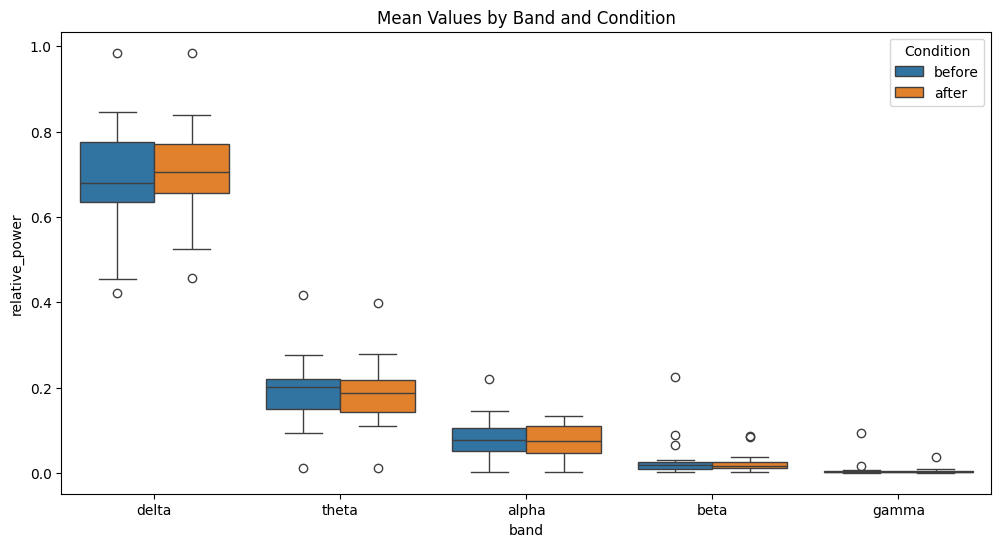

<Figure size 1200x600 with 0 Axes>

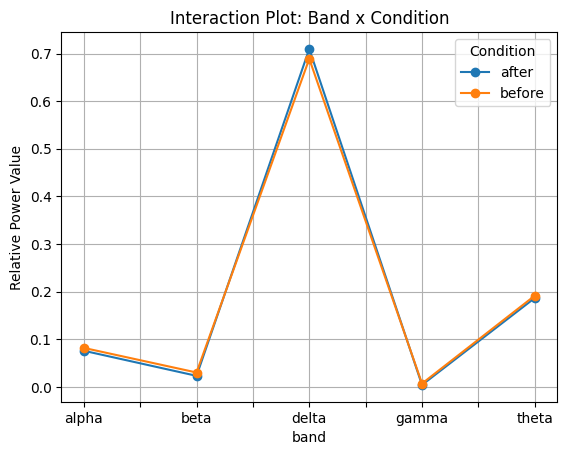

In [ ]:
# 결과 확인
print(results['anova_results'])
print(results['post_hoc_ttest'])
results['plot_function']()

In [ ]:
df_pivot

band,name,delta,theta,alpha,beta,gamma,Eye,Eye_TF
0,고정실,True,True,True,True,False,Y,True
1,김가람,True,True,True,False,False,Y-N,True
2,김득실,False,False,False,False,False,N,False
3,김영현,False,False,False,False,True,N,False
4,김정한,True,True,True,True,False,Y,True
5,김충연,True,True,True,True,True,Y-N,True
6,민병춘1,True,False,False,True,False,N,False
7,박주연1,False,False,False,True,False,N,False
8,박주연2,False,True,True,False,False,N,False
9,벌,True,True,False,False,False,N,False


In [54]:
import itertools

# 밴드 리스트
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

data = df_pivot.copy()

# 결과 저장
results = []

# 모든 조합 생성
for r in range(1, len(bands) + 1):  # 조합 크기 1부터 모든 밴드까지
    for combination in itertools.combinations(bands, r):
        # 진단 기준: 조합에 포함된 모든 밴드가 True인 경우
        data['diagnosis'] = data[list(combination)].all(axis=1)
        
        # 혼동 행렬 요소 계산
        TP = ((data['diagnosis'] == True) & (data['Eye_TF'] == True)).sum()
        TN = ((data['diagnosis'] == False) & (data['Eye_TF'] == False)).sum()
        FP = ((data['diagnosis'] == True) & (data['Eye_TF'] == False)).sum()
        FN = ((data['diagnosis'] == False) & (data['Eye_TF'] == True)).sum()
        
        # 민감도와 특이도 계산
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        
        # 결과 저장
        results.append({
            'combination': combination,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN
        })

# 결과를 데이터프레임으로 정리
results_df = pd.DataFrame(results)

# 결과 출력
display(results_df)

,combination,sensitivity,specificity,TP,TN,FP,FN
0,"(delta,)",1.000000,0.4375,6,7,9,0
1,"(theta,)",1.000000,0.4375,6,7,9,0
2,"(alpha,)",0.833333,0.5625,5,9,7,1
3,"(beta,)",0.833333,0.3750,5,6,10,1
4,"(gamma,)",0.333333,0.6250,2,10,6,4
5,"(delta, theta)",1.000000,0.5000,6,8,8,0
6,"(delta, alpha)",0.833333,0.6250,5,10,6,1
7,"(delta, beta)",0.833333,0.5000,5,8,8,1
8,"(delta, gamma)",0.333333,0.7500,2,12,4,4
9,"(theta, alpha)",0.833333,0.5625,5,9,7,1
